In [146]:
# TODO
# 1. Add new metrics in addition to accuracy: precision, recall, F1 score
# 2. Multilabel_classification
# 3. New datasets
# 4. To do a few experiments
# 5. Gradient checking
# 6. Mini-batch gradient descend

In [147]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn import datasets
from sklearn.model_selection import train_test_split
sns.set_theme(style="darkgrid")

## Class for implemantation NN

In [188]:
class NN:
    """
    Class for creating a NN, initializing and training its parameters and getting a prediction for a new data    
    """
    
    def __ReLU(self, Z):
        return np.maximum(0, Z)
        
    def __dReLU(self, Z):
        """
        Derivative of ReLU activation function
        """
        return (Z>0).astype(float) 
        
    def __sigmoid(self, Z):
        return 1/(1 + np.exp(-Z))
        
    def __dsigmoid(self, Z):
        """
        Derivative of sigmoid activation function
        """
        return self.__sigmoid(Z)*(1 - self.__sigmoid(Z))   
    
    def __tanh(self, Z):
        return (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))
    
    def __dtanh(self, Z):
        """
        Derivative of tanh activation function
        """
        return 1-self.__tanh(Z)**2
    
    def __LeakyReLU(self, Z, alpha):
        return np.maximum(alpha*Z, Z)
        
    def __dLeakyReLU(self, Z, alpha):
        """
        Derivative of Leaky ReLU activation function
        """
        d = (Z>0).astype(float)
        d[d==0] = alpha
        return d 
        
    def __softmax(self, Z):
        Z_ = Z - np.max(Z, axis=0)
        output = np.exp(Z_)/np.sum(np.exp(Z_), axis=0)
        return output
        
    def __dsoftmax(self, Z):
        """
        Derivative of softmax activation function
        """
        # shape of da_dz = (number_of_examples, number_of_classes, number_of_classes)
        # shape of Z = (number_of_classes, number_of_examples)
        # So strange shape of da_dz needs for future use matrices multiplication (@)
        # 
        da_dz = np.zeros((Z.shape[1], Z.shape[0], Z.shape[0]), dtype=float)
        g = self.__softmax(Z) # shape of g = (number_of_classes, number_of_examples)
        for i in range(Z.shape[0]): # row - z1, z2, ....
            for p in range(Z.shape[0]): # col - a1, a2, ...
                if i==p: 
                    da_dz[:,i,p] = g[i]*(1-g[i]) # for example da1/da1
                else:
                    da_dz[:,i,p] = -g[p]*g[i] # for example da1/da2
        return da_dz
    
    def __regularization_L2(self, m, lambda_=0.001):
        return lambda_*np.sum([np.sum(W**2) for W in self.W])/(2*m)

    def __dregularization_L2(self, m, lambda_=0.001):
        return [lambda_*W/m for W in self.W]
    
    def __binary_classification(self, Y, Y_hat, lambda_=0.001):
        m = Y.shape[1]
        cost = -np.sum(Y*np.log(Y_hat) + (1-Y)*np.log(1-Y_hat))/m
        regL2 = self.__regularization_L2(m, lambda_)
        return cost+regL2
    
    def __dbinary_classification(self, Y, Y_hat):
        """
        Derivative of cross-entropy cost function
        """        
        m = Y.shape[1]        
        return ((1-Y)/(1-Y_hat) - Y/Y_hat)/m
    
    def __multiclass_classification(self, Y, Y_hat, lambda_=0.001):
        m = Y.shape[1]
        cost = -np.sum(Y*np.log(Y_hat))/m
        regL2 = self.__regularization_L2(m, lambda_)
        return cost + regL2
    
    def __dmulticlass_classification(self, Y, Y_hat):
        """
        Derivative of cost function for multiclass classification
        """   
        m = Y.shape[1]
        d = -1*Y/(m*Y_hat)
        # So strange shape of derivative needs for future use matrices multiplication (@)
        # with derivative of softmax activation function
        return d.T[:,:,None]     
    
    def __multilabel_classification(self, Y, Y_hat):
        pass
    
    def __dmultilabel_classification(self, Y, Y_hat):
        """
        Derivative of cost function for multi-label classification
        """
        pass   
    
    def __init__(self, layers: List[Tuple], n_x: int, cost_function: str, W=None, b=None):
        """
        Initialization of NN
        
        :param layers: list of tuples of layer's parameters: (number_of_unit, activation_function). 
                       activation_function is string: "relu", "leakyrelu", "sigmoid", "tanh", "softmax"  
        :param n_x: size of input layer (number of features) 
        :param cost_function: view of cost function. Can be "binary_classification", "multiclass_classification", 
                              "multilabel_classification"
        :param W: default None. If None weight matrices will be initialized with random numbers 
                  from N(0,1) times 1/sqrt(size_current_layer+size_previous_layer)
        :param b: default None. If None b will be initialized with random numbers from N(0,1) 
        
        """
        self.L = len(layers)
        self.W, self.b, self.activations_func = [], [], []
        self.cost_function_name = cost_function.lower()
        count_units_in_previous_layer = n_x
        functions_dict = {"relu": (self.__ReLU, self.__dReLU),
                          "leakyrelu": (self.__LeakyReLU, self.__dLeakyReLU),
                          "sigmoid": (self.__sigmoid, self.__dsigmoid),
                          "tanh": (self.__tanh, self.__dtanh),
                          "softmax": (self.__softmax, self.__dsoftmax),
                         }
        cost_functions_dict = {"binary_classification": (self.__binary_classification, 
                                                         self.__dbinary_classification),
                               "multiclass_classification": (self.__multiclass_classification, 
                                                             self.__dmulticlass_classification),
                               "multilabel_classification": (self.__multilabel_classification, 
                                                             self.__dmultilabel_classification),
                              }
        
        for layer in layers:
            if W is None:
                self.W.append(np.random.randn(layer[0], count_units_in_previous_layer) * np.sqrt(1/(layer[0] + count_units_in_previous_layer)))
            else:
                self.W=W
            if b is None:
                self.b.append(np.random.randn(layer[0], 1))
            else:
                self.b=b
            self.activations_func.append(functions_dict.get(layer[1].lower()))
            count_units_in_previous_layer = layer[0]
        
        self.cost_function = cost_functions_dict.get(self.cost_function_name)[0]
        self.dcost_function = cost_functions_dict.get(self.cost_function_name)[1]
    
    def forward_prop(self, X):
        A_l, Z_l = [], []
        A = X
        for i in range(self.L):
            Z = np.dot(self.W[i], A) + self.b[i]
            A = self.activations_func[i][0](Z)
            A_l.append(A)
            Z_l.append(Z)
        return A_l, Z_l
    
    def evalute_cost_function(self, Y, Y_hat, lambda_=0.001):
        return self.cost_function(Y, Y_hat, lambda_)
    
    def backward_prop(self, X, Y, A_l, Z_l, lambda_=0.001):
        m = X.shape[1]
        dW_l, db_l = [], []
        dA = self.dcost_function(Y, A_l[-1])
        for i in range(self.L-1,-1,-1):
            if i==self.L-1 and self.cost_function_name == 'multiclass_classification':
                tmp = self.activations_func[i][1](Z_l[i])@dA                 
                dZ = np.squeeze(tmp).T
            else:
                dZ = dA * self.activations_func[i][1](Z_l[i])
            
            A_prev = A_l[i-1] if i>0 else X   
            dW = np.dot(dZ, A_prev.T) + self.__dregularization_L2(m, lambda_)[i]
            db = np.sum(dZ, axis=1, keepdims=True)
            dA = np.dot(self.W[i].T, dZ)
            dW_l.append(dW)
            db_l.append(db)
        return dW_l[::-1], db_l[::-1]
    
    def update_params(self,dW_l, db_l, learning_rate=0.001):
        for i in range(self.L):
            self.W[i] -= learning_rate*dW_l[i]
            self.b[i] -= learning_rate*db_l[i]
    
    def fit(self, X, Y, learning_rate=0.001, iterations_number=1000, lambda_=0.001,
            is_evaluate_accuracy=False, X_test=None, Y_test=None,
            print_frequency=100):
        """
        Train NN
        
        :param X: ndarray, train set with shape (number_of_features, number_of_examples) 
        :param Y: ndarray, ground truth for train set with shape (1, number_of_examples)  
        :param learning_rate: float, learning_rate for update weights
        :param iterations_number: int, number of iterations
        :param is_evaluate_accuracy: bool, evaluate or not accuracy on train set during training
        :param X_test: ndarray, test set with shape (number_of_features, number_of_examples). 
                       If (is_evaluate_accuracy=True) and (X_test is not None) will evaluate 
                       accuracy also on test set during training
        :param Y_test: ndarray, ground truth for test set with shape (1, number_of_examples)  
        :param print_frequency: int, frequency of print information during training (in number of iterations) 
        
        :returns
        J: list, cost function values in each iterations (size: iterations_number) 
        accuracy_train: list, accuracy values on train set (size: print_frequency) 
        accuracy_test: list, accuracy values on test set (size: print_frequency)
        W: list[ndarray], list of weight's matrices by layers
        b: list[ndarray], list of b matrices by layers
        """
        
        J = []; accuracy_test = []; accuracy_train = []
        acc_train_str = None; acc_test_str = None
        
        for i in range(1,iterations_number+1):
            A_l, Z_l = self.forward_prop(X)
            J.append(self.evalute_cost_function(Y, A_l[-1]))
            
            if is_evaluate_accuracy:
                Y_train_hat = self.predict(X)
                if self.cost_function_name == 'binary_classification':
                    acc = np.sum(Y == Y_train_hat)/Y.shape[1]
                elif self.cost_function_name == 'multiclass_classification':
                    acc = np.sum(Y*Y_train_hat)/Y.shape[1]
                accuracy_train.append(acc)
                if X_test is not None:            
                    Y_test_hat = self.predict(X_test)
                    if self.cost_function_name == 'binary_classification':
                        accuracy_test.append(np.sum(Y_test == Y_test_hat)/Y_test.shape[1])
                    elif self.cost_function_name == 'multiclass_classification':
                        accuracy_test.append(np.sum(Y_test*Y_test_hat)/Y_test.shape[1])

            dW_l, db_l = self.backward_prop(X, Y, A_l, Z_l, lambda_)
            self.update_params(dW_l, db_l, learning_rate=learning_rate)
            
            if not (i % print_frequency):
                if is_evaluate_accuracy:
                    acc_train_str = f"accuracy on train: {accuracy_train[-1]:.2f}"
                    if X_test is not None: 
                        acc_test_str = f"accuracy on test: {accuracy_test[-1]:.2f}"
                        
                print(f"iter {(i)}: cost={J[-1]:.4f} {acc_train_str} {acc_test_str}")
        return J, accuracy_train, accuracy_test, self.W, self.b
    
    def predict(self, X, therhold=0.5):
        A, _ = self.forward_prop(X)
        if self.cost_function_name == 'binary_classification':
            Y_hat =(A[-1]>therhold).astype(int)
        elif self.cost_function_name == 'multiclass_classification':
            Y_hat = (A[-1]==np.max(A[-1], axis=0)).astype("int")
        return Y_hat

## Some simple tests

In [189]:
def test_nn_one_layer_logistic_regression():
    X = np.array([[1,0,1,0],[0,1,1,0]])
    Y = np.array([[0, 1, 1, 1]])
    W = [np.array([[0.5, 0.5]])]
    b = [np.array([[1.]])]
    logistic_regression = NN([(1, 'sigmoid')],2,'binary_classification',W=W,b=b)
    A_l, Z_l = logistic_regression.forward_prop(X)
    Y_hat = A_l[-1]
    cost = logistic_regression.evalute_cost_function(Y, Y_hat)
    dW_l, db_l = logistic_regression.backward_prop(X, Y, A_l, Z_l)
    logistic_regression.update_params(dW_l, db_l, learning_rate=0.01)
    
    assert np.allclose(Z_l[0], [[1.5,1.5,2.,1.]]), "Wrong Z"
    assert np.allclose(A_l[0], [[0.81757448, 0.81757448, 0.88079708, 0.73105858]]), "Wrong A"
    assert cost == 0.5858165636316751, "Wrong cost function"
    assert np.allclose(dW_l[0], [[0.17471789, -0.07528211]]), "Wrong dW"
    assert np.allclose(db_l[0], [[0.06175115]]), "Wrong db"
    assert np.allclose(logistic_regression.W[0], [[0.49825282, 0.50075282]]), "Wrong W"
    assert np.allclose(logistic_regression.b[0], [[0.99938249]]), "Wrong b"    
    
    print("Tests passed")

In [190]:
test_nn_one_layer_logistic_regression()

Tests passed


## Test binary classification by example iris dataset

In [191]:
iris = datasets.load_iris()
data, target, target_names, feature_names = iris["data"], iris["target"], iris["target_names"], iris["feature_names"]

print(f"Data shape: {data.shape}. \n \
Data examples: {data[:2]}. \n \
Target shape: {target.shape}. \n \
Target examples: {target[:2]}. \n \
Target names: {target_names}. \n \
Feature names: {feature_names}")

Data shape: (150, 4). 
 Data examples: [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]]. 
 Target shape: (150,). 
 Target examples: [0 0]. 
 Target names: ['setosa' 'versicolor' 'virginica']. 
 Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [192]:
# Take only two classes from iris dataset^ target=0 and target=1

In [193]:
X = np.array(data[np.any(list(zip(target==0, target==1)),axis=1)])
Y = np.array(target[np.any(list(zip(target==0, target==1)),axis=1)]).reshape(-1,1)
print(f"X.shape={X.shape}, Y.shape={Y.shape}")

X.shape=(100, 4), Y.shape=(100, 1)


In [194]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8)
X_train = X_train.T
Y_train = Y_train.T
X_test = X_test.T
Y_test = Y_test.T
print(f"X_train.shape={X_train.shape}, Y_train.shape={Y_train.shape}, \
X_test.shape={X_test.shape}, Y_test.shape={Y_test.shape}")

X_train.shape=(4, 80), Y_train.shape=(1, 80), X_test.shape=(4, 20), Y_test.shape=(1, 20)


### Simple sigmoid with 4 input and 1 output 

In [195]:
logistic_regression = NN([(1, 'sigmoid')],4,'binary_classification')
J, accuracy_train, accuracy_test, _, _ = logistic_regression.fit(X_train, Y_train, learning_rate=0.1, iterations_number=100, 
                                                                 is_evaluate_accuracy=True, X_test=X_test, Y_test=Y_test, 
                                                                 print_frequency=10, lambda_=0.01)

iter 10: cost=0.3134 accuracy on train: 1.00 accuracy on test: 1.00
iter 20: cost=0.2224 accuracy on train: 1.00 accuracy on test: 1.00
iter 30: cost=0.1709 accuracy on train: 1.00 accuracy on test: 1.00
iter 40: cost=0.1384 accuracy on train: 1.00 accuracy on test: 1.00
iter 50: cost=0.1162 accuracy on train: 1.00 accuracy on test: 1.00
iter 60: cost=0.1002 accuracy on train: 1.00 accuracy on test: 1.00
iter 70: cost=0.0880 accuracy on train: 1.00 accuracy on test: 1.00
iter 80: cost=0.0785 accuracy on train: 1.00 accuracy on test: 1.00
iter 90: cost=0.0709 accuracy on train: 1.00 accuracy on test: 1.00
iter 100: cost=0.0647 accuracy on train: 1.00 accuracy on test: 1.00


[Text(0.5, 1.0, 'Accuracy on test set'),
 Text(0.5, 0, '# iter'),
 Text(0, 0.5, '%')]

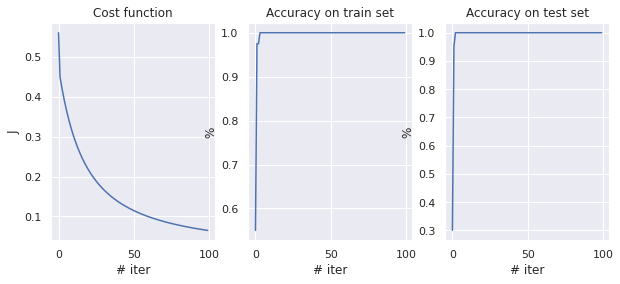

In [196]:
f, axs = plt.subplots(1, 3, figsize=(10, 4))
g1 = sns.lineplot(data=J, ax=axs[0])
g2 = sns.lineplot(data=accuracy_train, ax=axs[1])
g3 = sns.lineplot(data=accuracy_test, ax=axs[2])
g1.set(title='Cost function', xlabel='# iter', ylabel='J')
g2.set(title='Accuracy on train set', xlabel='# iter', ylabel='%')
g3.set(title='Accuracy on test set', xlabel='# iter', ylabel='%')

In [197]:
logistic_regression = NN([(3, 'relu'), (1, 'sigmoid')],4,'binary_classification')
J, acc_train, acc_test, _, _ = logistic_regression.fit(X_train, Y_train, learning_rate=0.1, iterations_number=500,
                                                       is_evaluate_accuracy=True, X_test=X_test, Y_test=Y_test,
                                                       print_frequency=10)

iter 10: cost=0.2384 accuracy on train: 1.00 accuracy on test: 1.00
iter 20: cost=0.1295 accuracy on train: 1.00 accuracy on test: 1.00
iter 30: cost=0.0802 accuracy on train: 1.00 accuracy on test: 1.00
iter 40: cost=0.0553 accuracy on train: 1.00 accuracy on test: 1.00
iter 50: cost=0.0412 accuracy on train: 1.00 accuracy on test: 1.00
iter 60: cost=0.0323 accuracy on train: 1.00 accuracy on test: 1.00
iter 70: cost=0.0263 accuracy on train: 1.00 accuracy on test: 1.00
iter 80: cost=0.0221 accuracy on train: 1.00 accuracy on test: 1.00
iter 90: cost=0.0189 accuracy on train: 1.00 accuracy on test: 1.00
iter 100: cost=0.0165 accuracy on train: 1.00 accuracy on test: 1.00
iter 110: cost=0.0146 accuracy on train: 1.00 accuracy on test: 1.00
iter 120: cost=0.0131 accuracy on train: 1.00 accuracy on test: 1.00
iter 130: cost=0.0118 accuracy on train: 1.00 accuracy on test: 1.00
iter 140: cost=0.0108 accuracy on train: 1.00 accuracy on test: 1.00
iter 150: cost=0.0099 accuracy on train: 1.

[Text(0.5, 1.0, 'Accuracy on test set'),
 Text(0.5, 0, '# iter'),
 Text(0, 0.5, '%')]

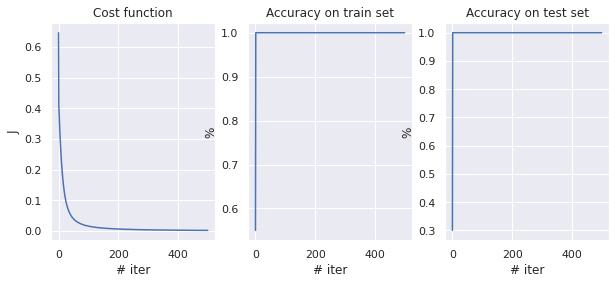

In [198]:
f, axs = plt.subplots(1, 3, figsize=(10, 4))
g1 = sns.lineplot(data=J, ax=axs[0])
g2 = sns.lineplot(data=acc_train, ax=axs[1])
g3 = sns.lineplot(data=acc_test, ax=axs[2])
g1.set(title='Cost function', xlabel='# iter', ylabel='J')
g2.set(title='Accuracy on train set', xlabel='# iter', ylabel='%')
g3.set(title='Accuracy on test set', xlabel='# iter', ylabel='%')

## Test binary classification by example not linearly separable set (from here: https://cs231n.github.io/neural-networks-case-study/) 

(-1.0, 1.0)

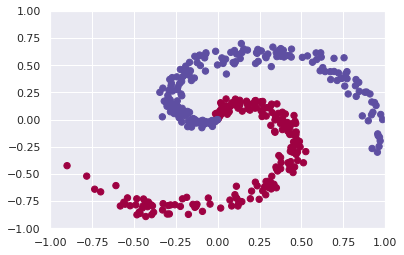

In [199]:
# np.random.seed(0)
N = 200 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes
X = np.zeros((N*K,D))
Y = np.zeros((N*K,1), dtype='uint8')
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [200]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8)
X_train = X_train.T
Y_train = Y_train.T
X_test = X_test.T
Y_test = Y_test.T
print(f"X_train.shape={X_train.shape}, Y_train.shape={Y_train.shape}, \
X_test.shape={X_test.shape}, Y_test.shape={Y_test.shape}")

X_train.shape=(2, 320), Y_train.shape=(1, 320), X_test.shape=(2, 80), Y_test.shape=(1, 80)


### Simple sigmoid

In [201]:
logistic_regression = NN([(1, 'sigmoid')],2,'binary_classification')
J, acc_train, acc_test, W, b = logistic_regression.fit(X_train, Y_train, learning_rate=0.1, iterations_number=1000, 
                                                                 is_evaluate_accuracy=True, X_test=X_test, Y_test=Y_test, 
                                                                 print_frequency=100, lambda_=0.01)

iter 100: cost=0.5669 accuracy on train: 0.77 accuracy on test: 0.74
iter 200: cost=0.4972 accuracy on train: 0.77 accuracy on test: 0.76
iter 300: cost=0.4629 accuracy on train: 0.77 accuracy on test: 0.76
iter 400: cost=0.4427 accuracy on train: 0.77 accuracy on test: 0.76
iter 500: cost=0.4297 accuracy on train: 0.77 accuracy on test: 0.75
iter 600: cost=0.4207 accuracy on train: 0.76 accuracy on test: 0.75
iter 700: cost=0.4143 accuracy on train: 0.77 accuracy on test: 0.74
iter 800: cost=0.4096 accuracy on train: 0.76 accuracy on test: 0.72
iter 900: cost=0.4059 accuracy on train: 0.76 accuracy on test: 0.72
iter 1000: cost=0.4031 accuracy on train: 0.75 accuracy on test: 0.72


[Text(0.5, 1.0, 'Accuracy on test set'),
 Text(0.5, 0, '# iter'),
 Text(0, 0.5, '%')]

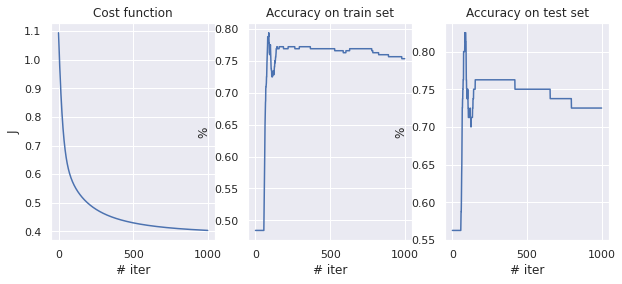

In [202]:
f, axs = plt.subplots(1, 3, figsize=(10, 4))
g1 = sns.lineplot(data=J, ax=axs[0])
g2 = sns.lineplot(data=acc_train, ax=axs[1])
g3 = sns.lineplot(data=acc_test, ax=axs[2])
g1.set(title='Cost function', xlabel='# iter', ylabel='J')
g2.set(title='Accuracy on train set', xlabel='# iter', ylabel='%')
g3.set(title='Accuracy on test set', xlabel='# iter', ylabel='%')

### <p style="color:red">Low accuracy: sigmoid works good only on linear separable set</p>

### Test NN with one hidden layer with 100 units and ReLU activation functions

In [205]:
logistic_regression = NN([(100, 'relu'), (1, 'sigmoid')],2,'binary_classification')
J, acc_train, acc_test, _, _ = logistic_regression.fit(X_train, Y_train, learning_rate=0.1, iterations_number=10000,
                                                       is_evaluate_accuracy=True, X_test=X_test, Y_test=Y_test,
                                                       print_frequency=1000, lambda_=0.1)

iter 1000: cost=0.3334 accuracy on train: 0.78 accuracy on test: 0.76
iter 2000: cost=0.2063 accuracy on train: 0.91 accuracy on test: 0.90
iter 3000: cost=0.1820 accuracy on train: 0.93 accuracy on test: 0.90
iter 4000: cost=0.1736 accuracy on train: 0.93 accuracy on test: 0.91
iter 5000: cost=0.1630 accuracy on train: 0.93 accuracy on test: 0.94
iter 6000: cost=0.1446 accuracy on train: 0.94 accuracy on test: 0.96
iter 7000: cost=0.1225 accuracy on train: 0.95 accuracy on test: 0.96
iter 8000: cost=0.1015 accuracy on train: 0.97 accuracy on test: 1.00
iter 9000: cost=0.0861 accuracy on train: 0.97 accuracy on test: 1.00
iter 10000: cost=0.0751 accuracy on train: 0.98 accuracy on test: 1.00


[Text(0.5, 1.0, 'Accuracy on test set'),
 Text(0.5, 0, '# iter'),
 Text(0, 0.5, '%')]

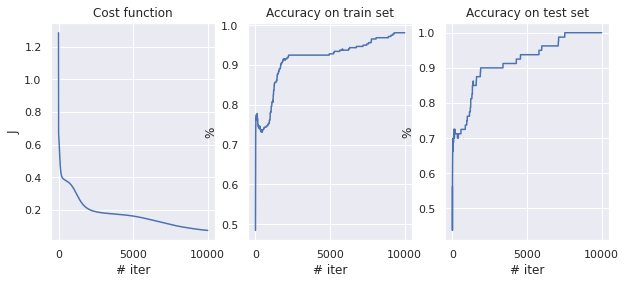

In [206]:
f, axs = plt.subplots(1, 3, figsize=(10, 4))
g1 = sns.lineplot(data=J, ax=axs[0])
g2 = sns.lineplot(data=acc_train, ax=axs[1])
g3 = sns.lineplot(data=acc_test, ax=axs[2])
g1.set(title='Cost function', xlabel='# iter', ylabel='J')
g2.set(title='Accuracy on train set', xlabel='# iter', ylabel='%')
g3.set(title='Accuracy on test set', xlabel='# iter', ylabel='%')

### <p style="color:green">Good accuracy: two layer NN works good</p>

(-1.0, 1.0)

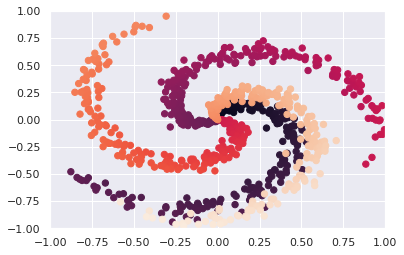

In [207]:
# np.random.seed(0)
N = 200 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes
X = np.zeros((N*K,D))
Y = np.zeros((N*K,K), dtype='uint8')
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y[ix,j] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=np.where(Y == 1)[0], s=40)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [208]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8)
X_train = X_train.T
Y_train = Y_train.T
X_test = X_test.T
Y_test = Y_test.T
print(f"X_train.shape={X_train.shape}, Y_train.shape={Y_train.shape}, \
X_test.shape={X_test.shape}, Y_test.shape={Y_test.shape}")

X_train.shape=(2, 640), Y_train.shape=(4, 640), X_test.shape=(2, 160), Y_test.shape=(4, 160)


In [211]:
logistic_regression = NN([(50, 'relu'), (50, 'relu'), (4, 'softmax')],2,'multiclass_classification')
J, acc_train, acc_test, _, _ = logistic_regression.fit(X_train, Y_train, learning_rate=0.1, iterations_number=30000,
                                                       is_evaluate_accuracy=True, X_test=X_test, Y_test=Y_test,
                                                       print_frequency=1000, lambda_=0.1)

iter 1000: cost=0.7902 accuracy on train: 0.59 accuracy on test: 0.60
iter 2000: cost=0.4052 accuracy on train: 0.81 accuracy on test: 0.81
iter 3000: cost=0.2732 accuracy on train: 0.87 accuracy on test: 0.89
iter 4000: cost=0.2105 accuracy on train: 0.91 accuracy on test: 0.89
iter 5000: cost=0.1812 accuracy on train: 0.92 accuracy on test: 0.91
iter 6000: cost=0.1630 accuracy on train: 0.93 accuracy on test: 0.91
iter 7000: cost=0.1514 accuracy on train: 0.93 accuracy on test: 0.91
iter 8000: cost=0.1415 accuracy on train: 0.94 accuracy on test: 0.91
iter 9000: cost=0.1379 accuracy on train: 0.94 accuracy on test: 0.91
iter 10000: cost=0.1335 accuracy on train: 0.94 accuracy on test: 0.91
iter 11000: cost=0.1303 accuracy on train: 0.94 accuracy on test: 0.91
iter 12000: cost=0.1279 accuracy on train: 0.95 accuracy on test: 0.91
iter 13000: cost=0.1235 accuracy on train: 0.95 accuracy on test: 0.91
iter 14000: cost=0.1217 accuracy on train: 0.95 accuracy on test: 0.91
iter 15000: cos

[Text(0.5, 1.0, 'Accuracy on test set'),
 Text(0.5, 0, '# iter'),
 Text(0, 0.5, '%')]

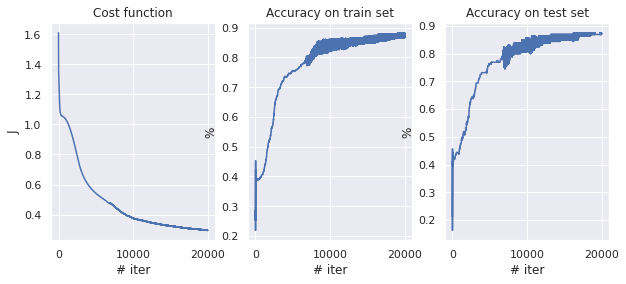

In [210]:
f, axs = plt.subplots(1, 3, figsize=(10, 4))
g1 = sns.lineplot(data=J, ax=axs[0])
g2 = sns.lineplot(data=acc_train, ax=axs[1])
g3 = sns.lineplot(data=acc_test, ax=axs[2])
g1.set(title='Cost function', xlabel='# iter', ylabel='J')
g2.set(title='Accuracy on train set', xlabel='# iter', ylabel='%')
g3.set(title='Accuracy on test set', xlabel='# iter', ylabel='%')